In [2]:

import os
import pandas as pd
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile

from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
from tabpfn import TabPFNClassifier
from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer,make_column_transformer


from tqdm.notebook import tqdm


import warnings  # Base category for warnings triggered during the process of importing a module (ignored by default)
warnings.filterwarnings('ignore') 

data_dir = './data'

In [ ]:
'''
# Аутентификация Kaggle API
api = KaggleApi()
api.authenticate()

# Параметры соревнования
competition_name = 'spaceship-titanic'
'''


'''
# Создайте директорию для данных
os.makedirs(data_dir, exist_ok=True)

# Скачайте данные
api.competition_download_files(competition_name, path=data_dir)

# Распакуйте ZIP-архив
zip_path = os.path.join(data_dir, 'spaceship-titanic.zip')
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_dir)'''

# Загрузите данные в Pandas
train_data_path = os.path.join(data_dir, 'train.csv')
test_data_path = os.path.join(data_dir, 'test.csv')

df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)

# Выведите первые строки
print("Train Data:")
display(df_train.head())

print("\nTest Data:")
display(df_test.head())

Train Data:


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True



Test Data:


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [78]:
df_train = df_train.dropna()
df_test = df_test.dropna()

Transported = df_train[['Transported']].reset_index()
#PassengerId_train = df_train[['PassengerId']]
#PassengerId_test = df_test[['PassengerId']]


#df_train = df_train.drop(['Transported','PassengerId' ], axis=1)
#df_test = df_test.drop(['PassengerId'], axis=1)
df_train = df_train.drop(['Transported'], axis=1)



dfs = [df_train, df_test]

In [79]:
all_in_one = pd.concat(dfs, sort=True).reset_index(drop=True)
all_in_one = all_in_one.fillna(0)

In [80]:
all_in_one[['FName', 'LName']] = all_in_one.Name.str.split(" ", expand=True) 
all_in_one  = all_in_one.drop(['Name','FName'],axis=1)
all_in_one  = all_in_one.drop(['HomePlanet'],axis=1)
all_in_one  = all_in_one.drop(['Destination'],axis=1)

all_in_one['Deck'] = all_in_one['Cabin'].apply(lambda k: k.split('/')[0])
all_in_one['Num'] = all_in_one['Cabin'].apply(lambda k: np.float64(k.split('/')[1]))
all_in_one['Side'] = all_in_one['Cabin'].apply(lambda k: k.split('/')[2])

all_in_one  = all_in_one.drop(['Cabin'],axis=1)



all_in_one[['Group', 'Id']] = all_in_one['PassengerId'].str.split(pat='_', expand=True) 
all_in_one  = all_in_one.drop(['PassengerId','Group'],axis=1)

all_in_one['LName'] = np.vectorize(hash)(all_in_one['LName'])
all_in_one

,Age,CryoSleep,FoodCourt,RoomService,ShoppingMall,Spa,VIP,VRDeck,LName,Deck,Num,Side,Id
0,39.0,False,0.0,0.0,0.0,0.0,False,0.0,2566422918520896259,B,0.0,P,01
1,24.0,False,9.0,109.0,25.0,549.0,False,44.0,-8840178564481026334,F,0.0,S,01
2,58.0,False,3576.0,43.0,0.0,6715.0,True,49.0,4301611783337572044,A,0.0,S,01
3,33.0,False,1283.0,0.0,371.0,3329.0,False,193.0,4301611783337572044,A,0.0,S,02
4,16.0,False,70.0,303.0,151.0,565.0,False,2.0,2344284669464683414,F,1.0,S,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9882,43.0,True,0.0,0.0,0.0,0.0,False,0.0,-4716702810694036232,G,1495.0,S,01
9883,43.0,False,0.0,47.0,3851.0,0.0,False,0.0,-7216713666011125640,D,278.0,S,01
9884,40.0,False,865.0,0.0,0.0,3.0,False,0.0,3599791159996587576,F,1796.0,S,01
9885,34.0,True,0.0,0.0,0.0,0.0,False,0.0,3599791159996587576,G,1496.0,S,02


In [81]:
print(all_in_one.describe())

               Age     FoodCourt   RoomService  ShoppingMall           Spa  \
count  9887.000000   9887.000000   9887.000000   9887.000000   9887.000000   
mean     28.790634    466.333468    222.047841    177.346920    307.704966   
std      14.395025   1618.846347    636.463513    573.968244   1125.206665   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     81.000000     51.000000     29.000000     59.500000   
max      79.000000  29813.000000  11567.000000  12253.000000  22408.000000   

             VRDeck         LName          Num  
count   9887.000000  9.887000e+03  9887.000000  
mean     302.643674  6.784332e+16   603.502579  
std     1142.410322  5.335256e+18   514.872790  
min        0.000000 -9.217660e+18     0.000000  
25%        0.000000 -4.578175e+18   169.000000  
50%

In [82]:
all_in_one = pd.get_dummies(all_in_one,dtype= np.float64)
all_in_one

,Age,CryoSleep,FoodCourt,RoomService,ShoppingMall,Spa,VIP,VRDeck,LName,Num,...,Side_P,Side_S,Id_01,Id_02,Id_03,Id_04,Id_05,Id_06,Id_07,Id_08
0,39.0,False,0.0,0.0,0.0,0.0,False,0.0,2566422918520896259,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,24.0,False,9.0,109.0,25.0,549.0,False,44.0,-8840178564481026334,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,58.0,False,3576.0,43.0,0.0,6715.0,True,49.0,4301611783337572044,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,33.0,False,1283.0,0.0,371.0,3329.0,False,193.0,4301611783337572044,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,16.0,False,70.0,303.0,151.0,565.0,False,2.0,2344284669464683414,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9882,43.0,True,0.0,0.0,0.0,0.0,False,0.0,-4716702810694036232,1495.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9883,43.0,False,0.0,47.0,3851.0,0.0,False,0.0,-7216713666011125640,278.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9884,40.0,False,865.0,0.0,0.0,3.0,False,0.0,3599791159996587576,1796.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9885,34.0,True,0.0,0.0,0.0,0.0,False,0.0,3599791159996587576,1496.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
s = StandardScaler()

all_in_one = pd.DataFrame(s.fit_transform(all_in_one), columns=all_in_one.columns)
all_in_one

,Age,CryoSleep,FoodCourt,RoomService,ShoppingMall,Spa,VIP,VRDeck,LName,Num,...,Side_P,Side_S,Id_01,Id_02,Id_03,Id_04,Id_05,Id_06,Id_07,Id_08
0,0.709265,-0.748138,-0.288080,-0.348895,-0.308999,-0.273479,-0.150857,-0.264930,0.468339,-1.172198,...,1.009247,-1.009247,0.628562,-0.441366,-0.262201,-0.165955,-0.117658,-0.095846,-0.066859,-0.042707
1,-0.332815,-0.748138,-0.282520,-0.177628,-0.265441,0.214456,-0.150857,-0.226413,-1.669737,-1.172198,...,-0.990838,0.990838,0.628562,-0.441366,-0.262201,-0.165955,-0.117658,-0.095846,-0.066859,-0.042707
2,2.029232,-0.748138,1.921012,-0.281331,-0.308999,5.694615,6.628794,-0.222036,0.793586,-1.172198,...,-0.990838,0.990838,0.628562,-0.441366,-0.262201,-0.165955,-0.117658,-0.095846,-0.066859,-0.042707
3,0.292433,-0.748138,0.504500,-0.348895,0.337410,2.685238,-0.150857,-0.095981,0.793586,-1.172198,...,-0.990838,0.990838,-1.590934,2.265695,-0.262201,-0.165955,-0.117658,-0.095846,-0.066859,-0.042707
4,-0.888590,-0.748138,-0.244837,0.127197,-0.045905,0.228676,-0.150857,-0.263179,0.426701,-1.170256,...,-0.990838,0.990838,0.628562,-0.441366,-0.262201,-0.165955,-0.117658,-0.095846,-0.066859,-0.042707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9882,0.987152,1.336653,-0.288080,-0.348895,-0.308999,-0.273479,-0.150857,-0.264930,-0.896825,1.731578,...,-0.990838,0.990838,0.628562,-0.441366,-0.262201,-0.165955,-0.117658,-0.095846,-0.066859,-0.042707
9883,0.987152,-0.748138,-0.288080,-0.275046,6.400770,-0.273479,-0.150857,-0.264930,-1.365431,-0.632232,...,-0.990838,0.990838,0.628562,-0.441366,-0.262201,-0.165955,-0.117658,-0.095846,-0.066859,-0.042707
9884,0.778737,-0.748138,0.246278,-0.348895,-0.308999,-0.270813,-0.150857,-0.264930,0.662035,2.316218,...,-0.990838,0.990838,0.628562,-0.441366,-0.262201,-0.165955,-0.117658,-0.095846,-0.066859,-0.042707
9885,0.361905,1.336653,-0.288080,-0.348895,-0.308999,-0.273479,-0.150857,-0.264930,0.662035,1.733521,...,-0.990838,0.990838,-1.590934,2.265695,-0.262201,-0.165955,-0.117658,-0.095846,-0.066859,-0.042707


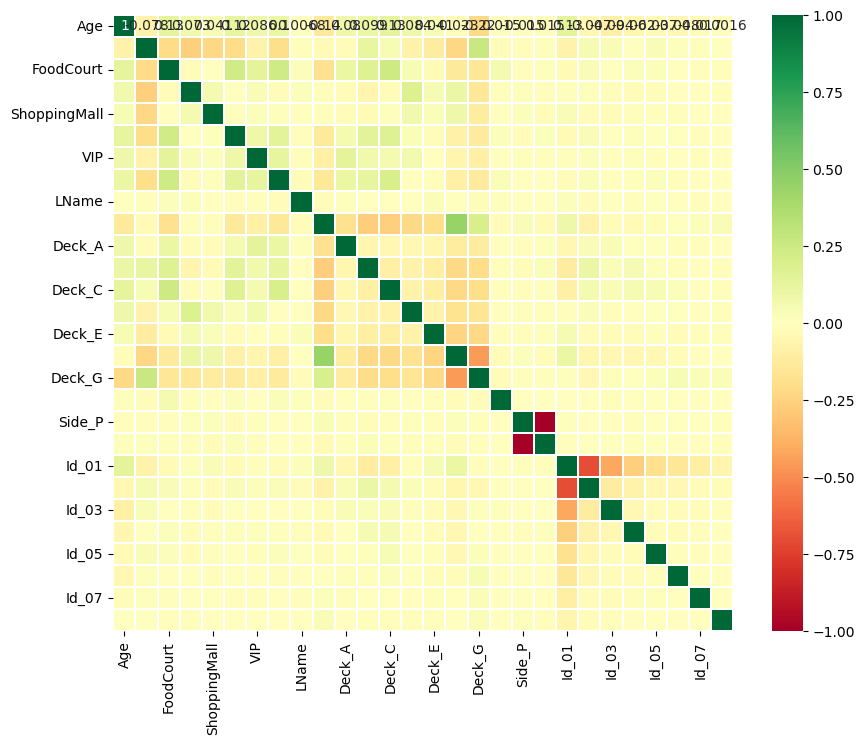

In [84]:
sns.heatmap(all_in_one.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

In [85]:
def return_data(all_in_one):
    return all_in_one.loc[:df_train.shape[0]-1], all_in_one.loc[df_train.shape[0]:]

train, test = return_data(all_in_one)
train = pd.concat([train,Transported], axis=1)

x = train.drop(['Transported'], axis=1)
y = train[['Transported']]

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Предполагается, что x и y уже загружены как pd.DataFrame и pd.Series соответственно.
# Например:
# x = pd.read_csv('data.csv')
# y = x.pop('target')  # если целевая переменная содержится в x

# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Определим набор моделей. Для некоторых моделей, чувствительных к масштабированию, применяем StandardScaler.
models = {
    "LogisticRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "SGDClassifier": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SGDClassifier(loss='log_loss', random_state=42))
    ]),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "SVC": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(probability=True, random_state=42))
    ]),
    "KNeighbors": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier())
    ]),
    "GaussianNB": GaussianNB()
}

results = {}

print("Обучение моделей на тренировочном наборе и оценка на тестовой выборке:\n")
for name, model in models.items():
    print(f"Модель: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"Точность на тестовой выборке: {acc:.4f}")
    print("Отчет по классификации:")
    print(classification_report(y_test, y_pred))
    print("-" * 40)

print("\nСравнение точности моделей:")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")

# Дополнительно можно провести кросс-валидацию для более стабильной оценки.
print("\nКросс-валидация (5-fold) для моделей:")
for name, model in models.items():
    scores = cross_val_score(model, x, y, cv=5, scoring='accuracy')
    print(f"{name}: {scores.mean():.4f} ± {scores.std():.4f}")

NameError: name 'x' is not defined

# Давай-ка начнем все с начала

идеас
* разделить возраст на группы

In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# 1. Загрузка данных
train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test = pd.read_csv(os.path.join(data_dir, 'test.csv'))

# Удаляем столбцы, которые не несут полезной информации для модели
train.drop(['Name'], axis=1, inplace=True)
test.drop(['Name'], axis=1, inplace=True)

# Функция для разделения информации по кабинету на составляющие (Deck, Num, Side)
def split_cabin(cabin):
    if pd.isnull(cabin):
        return pd.Series([np.nan, np.nan, np.nan])
    parts = cabin.split('/')
    if len(parts) == 3:
        return pd.Series(parts)
    else:
        return pd.Series([np.nan, np.nan, np.nan])

# Применяем функцию для train и test
train[['Deck', 'Num', 'Side']] = train['Cabin'].apply(split_cabin)
test[['Deck', 'Num', 'Side']] = test['Cabin'].apply(split_cabin)

train.drop(['Cabin'], axis=1, inplace=True)
test.drop(['Cabin'], axis=1, inplace=True)

# Преобразуем числовой признак номера каюты
train['Num'] = pd.to_numeric(train['Num'], errors='coerce')
test['Num'] = pd.to_numeric(test['Num'], errors='coerce')

# 2. Обработка пропущенных значений
# Пример: заполняем медианой для числовых признаков
if 'Age' in train.columns:
    train['Age'].fillna(train['Age'].median(), inplace=True)
if 'Age' in test.columns:
    test['Age'].fillna(test['Age'].median(), inplace=True)

# Заполнение остальных пропусков
train.fillna(method='ffill', inplace=True)
test.fillna(method='ffill', inplace=True)


train, test = train.drop(['Destination'], axis=1), test.drop(['Destination'], axis=1)

# 3. Преобразование категориальных признаков
categorical_cols = ['HomePlanet', 'Deck', 'Side', 'VIP', 'CryoSleep'] #, 'Destination'
train = pd.get_dummies(train, columns=categorical_cols, drop_first=True)
test = pd.get_dummies(test, columns=categorical_cols, drop_first=True)

# Выровнять наборы данных, чтобы они имели одинаковые признаки
train, test = train.align(test, join='left', axis=1, fill_value=0)


# 4. Подготовка данных для обучения
y = train['Transported'].astype(int)
X = train.drop(['Transported', 'PassengerId'], axis=1)

'''dropbox = ['Destination_PSO J318.5-22']
for i in dropbox:
    X = X.drop([i], axis=1)
    test = test.drop([i], axis=1)'''


X

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Num,HomePlanet_Europa,HomePlanet_Mars,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_S,VIP_True,CryoSleep_True
0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,True,False,False,False,False,False,False,False,False,False
1,24.0,109.0,9.0,25.0,549.0,44.0,0.0,False,False,False,False,False,False,True,False,False,True,False,False
2,58.0,43.0,3576.0,0.0,6715.0,49.0,0.0,True,False,False,False,False,False,False,False,False,True,True,False
3,33.0,0.0,1283.0,371.0,3329.0,193.0,0.0,True,False,False,False,False,False,False,False,False,True,False,False
4,16.0,303.0,70.0,151.0,565.0,2.0,1.0,False,False,False,False,False,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,41.0,0.0,6819.0,0.0,1643.0,74.0,98.0,True,False,False,False,False,False,False,False,False,False,True,False
8689,18.0,0.0,0.0,0.0,0.0,0.0,1499.0,False,False,False,False,False,False,False,True,False,True,False,True
8690,26.0,0.0,0.0,1872.0,1.0,0.0,1500.0,False,False,False,False,False,False,False,True,False,True,False,False
8691,32.0,0.0,1049.0,0.0,353.0,3235.0,608.0,True,False,False,False,False,True,False,False,False,True,False,False


In [48]:
test_ids = test['PassengerId']
X_test = test.drop(['Transported', 'PassengerId'], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Обучение модели RandomForest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_val)
print("Random Forest Accuracy:", accuracy_score(y_val, y_pred_rf))

# 6. Обучение модели с использованием XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.1,
    'max_depth': 6,
    'seed': 42
}
bst = xgb.train(params, dtrain, num_boost_round=100, evals=[(dval, 'validation')])
y_pred_xgb = (bst.predict(xgb.DMatrix(X_val)) > 0.5).astype(int)
print("XGBoost AUC:", roc_auc_score(y_val, y_pred_xgb))

Random Forest Accuracy: 0.7843588269120184
[0]	validation-auc:0.84929
[1]	validation-auc:0.85314
[2]	validation-auc:0.85687
[3]	validation-auc:0.86421
[4]	validation-auc:0.86579
[5]	validation-auc:0.86628
[6]	validation-auc:0.86767
[7]	validation-auc:0.86892
[8]	validation-auc:0.86960
[9]	validation-auc:0.87094
[10]	validation-auc:0.87171
[11]	validation-auc:0.87193
[12]	validation-auc:0.87349
[13]	validation-auc:0.87337
[14]	validation-auc:0.87435
[15]	validation-auc:0.87495
[16]	validation-auc:0.87805
[17]	validation-auc:0.87888
[18]	validation-auc:0.87882
[19]	validation-auc:0.88078
[20]	validation-auc:0.88129
[21]	validation-auc:0.88122
[22]	validation-auc:0.88202
[23]	validation-auc:0.88297
[24]	validation-auc:0.88324
[25]	validation-auc:0.88377
[26]	validation-auc:0.88473
[27]	validation-auc:0.88525
[28]	validation-auc:0.88565
[29]	validation-auc:0.88600
[30]	validation-auc:0.88608
[31]	validation-auc:0.88637
[32]	validation-auc:0.88654
[33]	validation-auc:0.88665
[34]	validation

In [49]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [100],
    'subsample': [0.75, 0.8, 0.85],
    'colsample_bytree': [0.75, 0.8, 0.85],
    'reg_alpha': [0, 0.01, 0.1, 1],  # L1-регуляризация
    'reg_lambda': [0.01, 0.1, 1, 10]  # L2-регуляризация
}


xgb_clf = XGBClassifier(random_state=42, objective='binary:logistic', eval_metric='auc')
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X, y)  # используйте весь тренировочный набор или CV
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший AUC:", grid_search.best_score_)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


KeyboardInterrupt: 

In [ ]:
final_pred=grid_search.predict(X_test)
submission = pd.DataFrame({
    'PassengerId': test_ids,
    'Transported': final_pred.astype(bool)
})
submission.to_csv("submission.csv", index=False)
submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,False
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


# Танцы с бубнами

In [ ]:
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()
numerical_cols

In [ ]:
# Вычисляем границы на основе тренировочных данных
bounds = {}
for col in numerical_cols:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    bounds[col] = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

# Применяем к тренировочным данным
for col in numerical_cols:
    lower, upper = bounds[col]
    X[col] = np.where(X[col] < lower, lower, X[col])
    X[col] = np.where(X[col] > upper, upper, X[col])

# Применяем те же границы к тестовым данным
for col in numerical_cols:
    lower, upper = bounds[col]
    test[col] = np.where(test[col] < lower, lower, test[col])
    test[col] = np.where(test[col] > upper, upper, test[col])
    
for col in numerical_cols:
    X[col] = np.log1p(X[col])  # Добавляем 1, чтобы избежать log(0)
    test[col] = np.log1p(test[col])
    
plt.figure(figsize=(12, 6))
X.boxplot()
plt.yscale('log')
plt.title('Boxplot после обработки выбросов')
plt.show()

## Идеи

In [23]:
import lightgbm as lgb
import xgboost as xgb
import shap
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBM
lgb_model = lgb.LGBMClassifier(n_estimators=200, learning_rate=0.05, max_depth=4, subsample=0.8, colsample_bytree=0.8, random_state=42)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict_proba(X_test)[:, 1]
auc_lgb = roc_auc_score(y_test, y_pred_lgb)
print(f"LightGBM AUC: {auc_lgb:.5f}")

# XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=4, subsample=0.8, colsample_bytree=0.8, use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict_proba(X_test)[:, 1]
auc_xgb = roc_auc_score(y_test, y_pred_xgb)
print(f"XGBoost AUC: {auc_xgb:.5f}")

LightGBM AUC: 0.86776
XGBoost AUC: 0.86830


In [44]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [50,100],
    'subsample': [0.75, 0.8, 0.85],
    'colsample_bytree': [0.75, 0.8, 0.85],
    'reg_alpha': [0, 0.01, 0.1, 1],  # L1-регуляризация
    'reg_lambda': [0.01, 0.1, 1, 10]  # L2-регуляризация
}


xgb_clf = LGBMClassifier(random_state=42, eval_metric='auc')
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X, y)  # используйте весь тренировочный набор или CV
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший AUC:", grid_search.best_score_)

Fitting 5 folds for each of 2592 candidates, totalling 12960 fits


KeyboardInterrupt: 

In [43]:
xgb_clf = LGBMClassifier(random_state=42, eval_metric='auc')
xgb_clf.fit(X, y)

LGBMClassifier(eval_metric='auc', random_state=42)

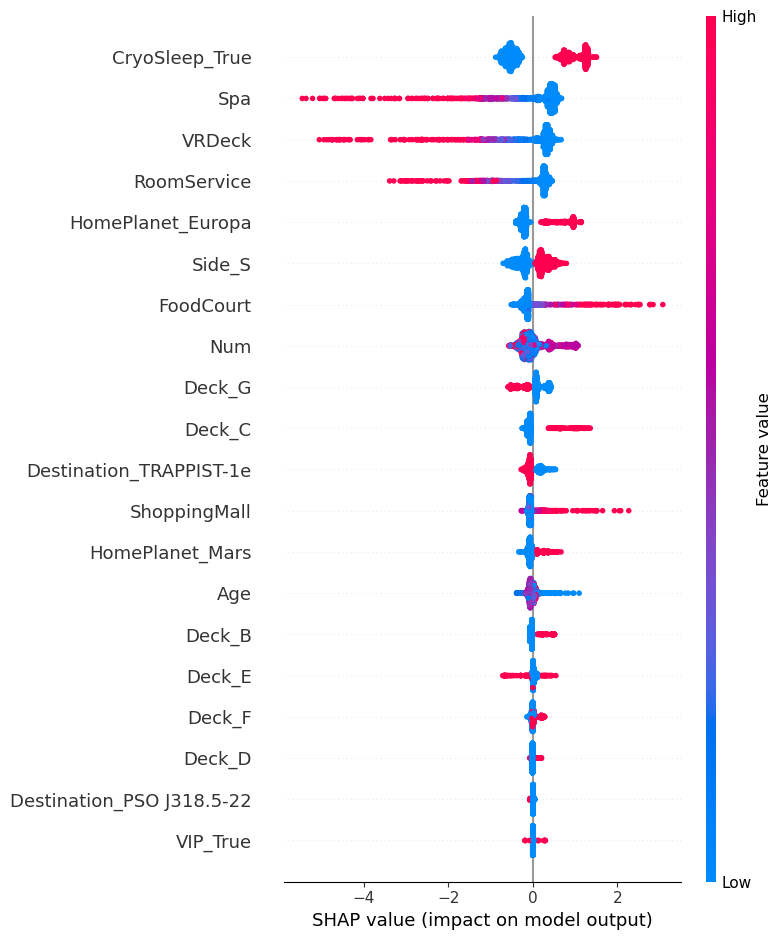

In [ ]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)

# Визуализация важности признаков
shap.summary_plot(shap_values, X_test)

## Идеи оказались говной

In [ ]:
xgb_model = XGBClassifier(n_estimators=1000, learning_rate=0.1, max_depth=5, subsample=0.85, colsample_bytree=0.75,reg_alpha =1,reg_lambda=10, use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(X, y)

# Score: 0.75917

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

stacking_model = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('xgb', XGBClassifier(colsample_bytree= 0.75, learning_rate= 0.1, max_depth=5, n_estimators = 100, reg_alpha= 1, reg_lambda = 10, subsample  = 0.85, random_state=42))
    ],
    final_estimator=LogisticRegression()
)

stacking_model.fit(X_train, y_train)

# Score: 0.80149

StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.75,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_t...one,
                                              interaction_constraints=None,
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=5,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))],
                   final_estimator=LogisticRegression())

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=200, random_state=42)),
        ('xgb', XGBClassifier(colsample_bytree= 0.75, learning_rate= 0.1, max_depth=5, n_estimators = 100, reg_alpha= 1, reg_lambda = 10, subsample  = 0.85, random_state=42))
    ],
    voting='soft'
)
voting_clf.fit(X_train, y_train)
print("Voting ensemble accuracy:", accuracy_score(y_val, voting_clf.predict(X_val)))

# Score: 0.78933

Voting ensemble accuracy: 0.8039102932719954


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf_model, X, y, cv=skf, scoring='roc_auc')
print("Средний AUC по кросс-валидации:", scores.mean())

Средний AUC по кросс-валидации: 0.882426343728812
